In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

OSError: ignored

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)

In [3]:
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

Cleaning the data

In [4]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
#We will need to replace the missing values with something. It doesnt generally matter too much what we choose. We will use the most common values . We can use the mode function  for that. One wrinkle is that it return more than one row in the case of ties, so we just grab the first row with iloc[0]:


modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [7]:
#We will fill the missing data with the mode values

df.fillna(modes, inplace=True)
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
#Here's how we get a quick summary of all the numeric columns in the dataset

import numpy as np
df.describe(include=(np.number)).columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


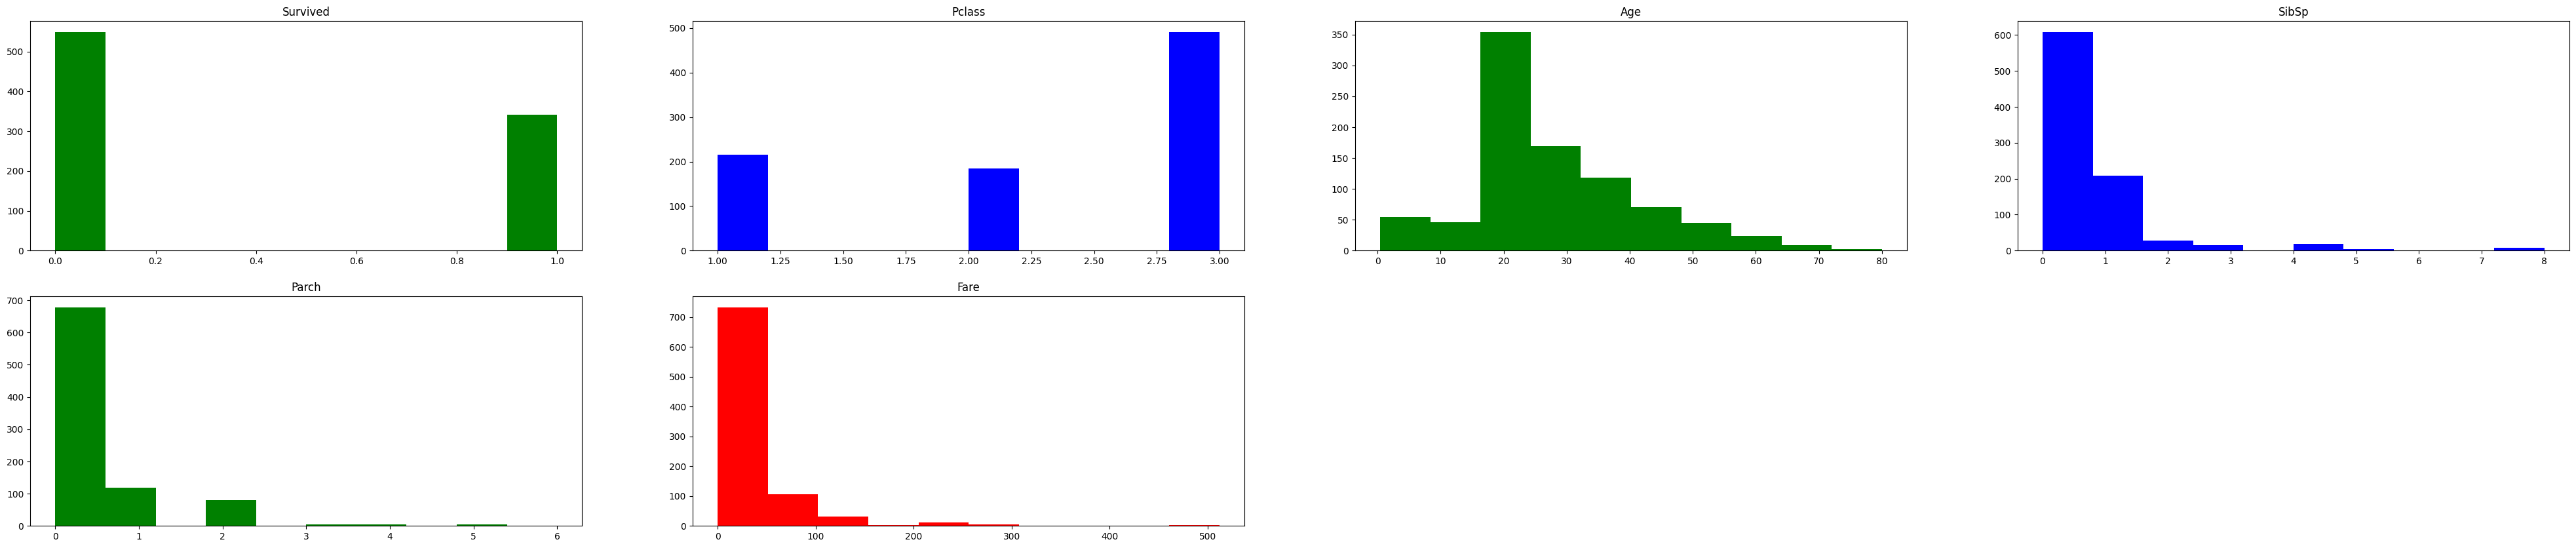

In [10]:
import enum
plt.figure(figsize=(50,10))
for i,j in enumerate(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']):
    plt.subplot(2,4,i+1)
    plt.hist(df[j],color=np.random.choice(['r','y','b','g']))
    plt.title(j)
    #plt.axis('off')

<Axes: >

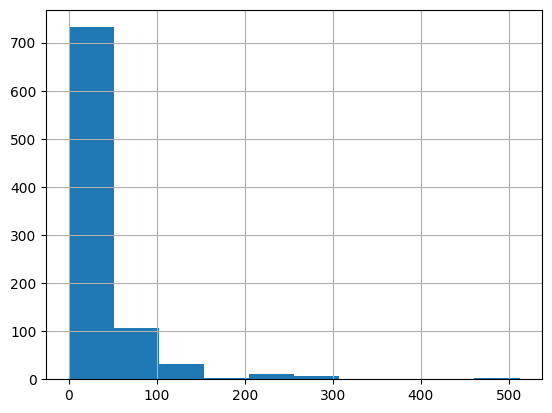

In [11]:
df['Fare'].hist()

In [12]:
#Clearly the 'Fare' Values are skewed to the left
#So we will log it and plot
df['Logfare'] = np.log(df['Fare']+1)


#There are zeroes in the column to fix this we add +1

<Axes: >

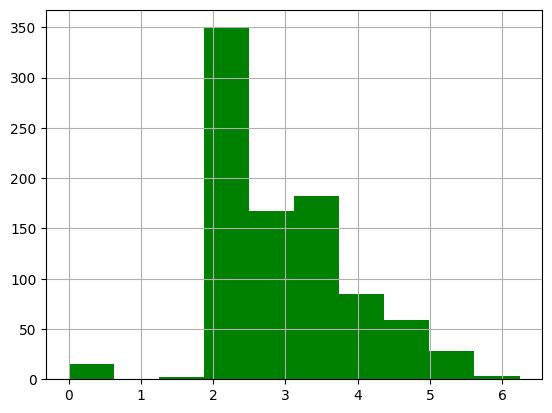

In [13]:
df['Logfare'].hist(color='g')

In [14]:
pclass = sorted(df.Pclass.unique())
pclass

[1, 2, 3]

In [15]:
#Quick summary of the non numeric components

df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [16]:
#Creating dummy variables 
df = pd.get_dummies(df, columns=['Sex', 'Pclass', "Embarked"])

In [17]:
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Logfare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [18]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [19]:
#Create our independent predictiors and dependent target variables

from torch import tensor
t_dep = tensor(df.Survived)
t_dep

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 

In [20]:
added_cols

['Sex_male',
 'Sex_female',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

Our independent variables are all the continuous variables of interest plus all the dummy variables we jsut created:

In [21]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Logfare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,2.202765,0,1,0,0,1,0,0,1


In [22]:
df.rename({'Logfare':'LogFare'},axis=1,inplace=True)

Converting to tensor

In [23]:
indep_cols = ['Age','SibSp','Parch','LogFare'] + added_cols
deps = torch.tensor(df.Survived).to(torch.float32)
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep.shape

torch.Size([891, 12])

Setting up a linear model

In [24]:
torch.manual_seed(43)
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)
coeffs

tensor([0.4540, 0.1965, 0.9210, 0.3462, 0.1481, 0.0858, 0.5909, 0.0659, 0.7476, 0.6253, 0.9392, 0.1338])

In [25]:
#These are the weights initialized
#next we need to multiply the coefficients with the feature vectors

t_indep*coeffs + 0.001

tensor([[    9.9883,     0.1975,     0.0010,     0.7315,     0.1491,     0.0010,     0.0010,     0.0010,     0.7486,     0.0010,     0.0010,
             0.1348],
        [   17.2518,     0.1975,     0.0010,     1.4829,     0.0010,     0.0868,     0.5919,     0.0010,     0.0010,     0.6263,     0.0010,
             0.0010],
        [   11.8042,     0.0010,     0.0010,     0.7587,     0.0010,     0.0868,     0.0010,     0.0010,     0.7486,     0.0010,     0.0010,
             0.1348],
        [   15.8899,     0.1975,     0.0010,     1.3825,     0.0010,     0.0868,     0.5919,     0.0010,     0.0010,     0.0010,     0.0010,
             0.1348],
        [   15.8899,     0.0010,     0.0010,     0.7636,     0.1491,     0.0010,     0.0010,     0.0010,     0.7486,     0.0010,     0.0010,
             0.1348],
        [   10.8962,     0.0010,     0.0010,     0.7788,     0.1491,     0.0010,     0.0010,     0.0010,     0.7486,     0.0010,     0.9402,
             0.0010],
        [   24.5153,  

In [26]:
#clearly the value of the first column is way large than the rest
#So we will do the following

vals, indices = t_indep.max(dim=0)
t_indep = t_indep/vals

In [27]:
t_indep #Much better

tensor([[0.2750, 0.1250, 0.0000, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.0000, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.0000, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.8333, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 

In [28]:
t_indep*coeffs+0.001

tensor([[0.1258, 0.0256, 0.0010, 0.1181, 0.1491, 0.0010, 0.0010, 0.0010, 0.7486, 0.0010, 0.0010, 0.1348],
        [0.2166, 0.0256, 0.0010, 0.2384, 0.0010, 0.0868, 0.5919, 0.0010, 0.0010, 0.6263, 0.0010, 0.0010],
        [0.1485, 0.0010, 0.0010, 0.1224, 0.0010, 0.0868, 0.0010, 0.0010, 0.7486, 0.0010, 0.0010, 0.1348],
        [0.1996, 0.0256, 0.0010, 0.2224, 0.0010, 0.0868, 0.5919, 0.0010, 0.0010, 0.0010, 0.0010, 0.1348],
        [0.1996, 0.0010, 0.0010, 0.1232, 0.1491, 0.0010, 0.0010, 0.0010, 0.7486, 0.0010, 0.0010, 0.1348],
        [0.1372, 0.0010, 0.0010, 0.1256, 0.1491, 0.0010, 0.0010, 0.0010, 0.7486, 0.0010, 0.9402, 0.0010],
        [0.3074, 0.0010, 0.0010, 0.2211, 0.1491, 0.0010, 0.5919, 0.0010, 0.0010, 0.0010, 0.0010, 0.1348],
        ...,
        [0.1429, 0.0010, 0.0010, 0.1167, 0.1491, 0.0010, 0.0010, 0.0010, 0.7486, 0.0010, 0.0010, 0.1348],
        [0.2223, 0.0010, 0.7685, 0.1899, 0.0010, 0.0868, 0.0010, 0.0010, 0.7486, 0.0010, 0.9402, 0.0010],
        [0.1542, 0.0010, 0.0010, 

In [29]:
#make predictions

t_preds = ((t_indep*coeffs)+0.001).sum(axis=1)
t_preds.view(-1,1)

tensor([[1.3079],
        [1.7917],
        [1.2482],
        [1.2671],
        [1.3623],
        [2.1077],
        [1.4113],
        [1.4517],
        [1.5779],
        [1.0837],
        [1.3394],
        [1.3356],
        [1.2771],
        [2.2476],
        [1.1796],
        [0.7668],
        [2.2989],
        [0.6424],
        [1.3430],
        [1.7238],
        [0.7412],
        [0.6991],
        [1.9918],
        [1.2432],
        [1.4234],
        [2.1798],
        [1.7861],
        [1.6826],
        [2.0419],
        [1.2989],
        [1.7896],
        [1.7518],
        [2.0411],
        [0.8698],
        [1.8050],
        [1.3679],
        [1.7861],
        [1.2828],
        [1.2938],
        [1.7137],
        [1.3610],
        [0.6468],
        [1.7904],
        [1.3458],
        [2.0136],
        [1.2998],
        [2.1631],
        [2.0411],
        [1.8915],
        [1.2686],
        [1.5385],
        [1.2813],
        [1.8582],
        [0.6695],
        [2.1285],
        [1

In [30]:
t_preds[:10]

tensor([1.3079, 1.7917, 1.2482, 1.2671, 1.3623, 2.1077, 1.4113, 1.4517, 1.5779, 1.0837])

In [31]:
#Since these predictions are meaningless as the weights or coefficients are randomly 
#initialized


#next we will calculate gradient descent and define a loss function

loss = np.abs(t_preds-deps).mean()

In [32]:
loss

tensor(1.0620)

In [33]:
#Next we will have to calculate the gradients and then modify the weights to minimize the loss

#But first lets define the loss and predict function for our convenience

def calc_preds(coeffs, t_indep):
    return ((t_indep*coeffs)+0.01).sum(axis=1)

def calc_loss(coeffs, t_indep, deps):
    return torch.abs(calc_preds(coeffs,t_indep)-deps).mean()


Doing a gradient descent step

In [34]:
coeffs.requires_grad_()

tensor([0.4540, 0.1965, 0.9210, 0.3462, 0.1481, 0.0858, 0.5909, 0.0659, 0.7476, 0.6253, 0.9392, 0.1338], requires_grad=True)

In [35]:
loss = calc_loss(coeffs,t_indep,deps)
loss

tensor(1.1531, grad_fn=<MeanBackward0>)

In [36]:
#calculate the gradient
loss.backward()

In [37]:
coeffs.grad

tensor([0.3106, 0.0570, 0.0520, 0.4038, 0.6139, 0.2379, 0.2424, 0.0584, 0.5511, 0.1886, 0.0864, 0.5769])

In [38]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([0.6211, 0.1139, 0.1040, 0.8077, 1.2278, 0.4759, 0.4848, 0.1167, 1.1021, 0.3771, 0.1728, 1.1538])

In [39]:
#Running backward everytime modifies the grad values as usual, second time the grad is calculated it calculated the slope of the grad function itself which is unnecessary


In [40]:
#Lets do one gradient descent step and check that our loss decreases

loss = calc_loss(coeffs, t_indep, deps)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad*0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.7547)


In [ ]:
!pip install fastai
!pip install fastbook
#fastbook.setup()

In [44]:
import fastai

In [ ]:
fastai.data.transform

In [47]:
#lets split the data into training and test

from fastai.data.transforms import RandomSplitter

In [48]:
trn_split, val_split = RandomSplitter(seed=42)(df)


In [78]:
trn_indep,val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = deps[trn_split], deps[val_split]

In [52]:
trn_indep.shape, trn_dep.shape

(torch.Size([713, 12]), torch.Size([713]))

In [58]:
#Create functions for the three things we did manually above

def update_coeffs(coeffs, lr):
  coeffs.sub_(coeffs.grad*lr)
  coeffs.grad.zero_()

In [64]:
def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, trn_indep, trn_dep)
  loss.backward()
  with torch.no_grad():
    update_coeffs(coeffs, lr)
  print(f"{loss:.3f}", end=";")

In [113]:
def init_coeffs():
  return (torch.rand(n_coeff)).requires_grad_()

In [114]:
#We can now use these functions to train our model

def train_model(epochs=30, lr=0.01):
  torch.manual_seed(43)
  coeffs = init_coeffs()
  for i in range(epochs):
    one_epoch(coeffs, lr=lr)
  return coeffs

In [115]:
coeffs = train_model(18,lr=0.2)

#This function returns the coefficients but prints the loss simultaneously

1.154;0.866;0.663;0.545;0.465;0.412;0.396;0.389;0.378;0.380;0.349;0.346;0.345;0.358;0.328;0.323;0.318;0.313;

In [116]:
coeffs

tensor([ 0.1567,  0.1015,  0.8466,  0.0482, -0.4539,  0.0499,  0.4153,  0.2241,  0.1271,  0.2870,  0.6688,  0.1046], requires_grad=True)

In [117]:
def show_coeffs():
  return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(0.1567),
 'SibSp': tensor(0.1015),
 'Parch': tensor(0.8466),
 'LogFare': tensor(0.0482),
 'Sex_male': tensor(-0.4539),
 'Sex_female': tensor(0.0499),
 'Pclass_1': tensor(0.4153),
 'Pclass_2': tensor(0.2241),
 'Pclass_3': tensor(0.1271),
 'Embarked_C': tensor(0.2870),
 'Embarked_Q': tensor(0.6688),
 'Embarked_S': tensor(0.1046)}

Measuring Accuracy

In [118]:
val_indep.shape

torch.Size([178, 12])

In [119]:
preds = calc_preds(coeffs, val_indep)

In [120]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True, False,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [121]:
#Lets see what our average accuracy is 

results.float().mean()

tensor(0.7472)

In [122]:
#We will create a function so we can calculate teh accuarcy easy for other models
#  we train

In [123]:
def acc(coeffs):
  return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7472)

## Using sigmoid

In [124]:
!pip install sympy

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5))

In [172]:
def calc_pred(coeffs, indeps):
  return torch.sigmoid(((indeps*coeffs))).sum(axis=1)

In [173]:
coeffs = train_model(epochs=500,lr=0.51)

1.154;0.560;0.441;0.446;0.439;0.428;0.389;0.408;0.402;0.414;0.415;0.447;0.411;0.402;0.374;0.323;0.438;0.471;0.401;0.471;0.372;0.406;0.382;0.464;0.368;0.333;0.395;0.502;0.381;0.477;0.358;0.403;0.376;0.496;0.344;0.349;0.363;0.530;0.375;0.469;0.356;0.432;0.346;0.418;0.341;0.489;0.342;0.446;0.375;0.493;0.331;0.358;0.341;0.512;0.387;0.494;0.333;0.381;0.319;0.482;0.415;0.482;0.338;0.397;0.299;0.388;0.427;0.500;0.388;0.481;0.328;0.362;0.326;0.495;0.401;0.492;0.331;0.382;0.310;0.441;0.447;0.462;0.339;0.420;0.328;0.438;0.367;0.514;0.331;0.388;0.294;0.424;0.471;0.454;0.327;0.402;0.353;0.503;0.346;0.435;0.317;0.379;0.360;0.547;0.340;0.415;0.300;0.380;0.419;0.503;0.369;0.478;0.320;0.369;0.302;0.455;0.442;0.470;0.335;0.418;0.325;0.438;0.368;0.493;0.338;0.406;0.288;0.377;0.452;0.480;0.372;0.480;0.320;0.378;0.301;0.465;0.425;0.485;0.335;0.409;0.311;0.406;0.387;0.517;0.346;0.416;0.290;0.374;0.410;0.512;0.360;0.476;0.319;0.383;0.303;0.459;0.424;0.487;0.330;0.406;0.306;0.428;0.408;0.499;0.334;0.397;0.29

In [174]:
acc(coeffs)

tensor(0.8371)

In [177]:
#That has improed

show_coeffs()

{'Age': tensor(-0.4865),
 'SibSp': tensor(-0.4923),
 'Parch': tensor(-0.1655),
 'LogFare': tensor(0.2359),
 'Sex_male': tensor(-0.5600),
 'Sex_female': tensor(0.1116),
 'Pclass_1': tensor(0.3420),
 'Pclass_2': tensor(0.2734),
 'Pclass_3': tensor(0.1067),
 'Embarked_C': tensor(0.3721),
 'Embarked_Q': tensor(0.3713),
 'Embarked_S': tensor(0.2726)}

In [179]:
tst_df = pd.read_csv('test.csv')
tst_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [180]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [181]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns = ["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep/vals

In [182]:
tst_indep

tensor([[0.4313, 0.0000, 0.0000, 0.3490, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.5875, 0.1250, 0.0000, 0.3332, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.7750, 0.0000, 0.0000, 0.3796, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.0000, 0.3634, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.2750, 0.1250, 0.1667, 0.4145, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.1750, 0.0000, 0.0000, 0.3725, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3750, 0.0000, 0.0000, 0.3453, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        ...,
        [0.4625, 0.1250, 0.0000, 0.7228, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.3500, 0.0000, 0.0000, 0.3480, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.0000, 

In [183]:
#Lets calculate the predictions of which passengers survived in the test set



In [184]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

Submit to Kaggle

In [185]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [186]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


Doing calculations in a more neater way

In [188]:
#till now we were doing

(val_indep*coeffs).sum(axis=1)

tensor([ 0.7082, -0.1461, -0.1475,  0.0393, -0.0664, -0.1656,  0.6393,  0.5870, -0.4035,  0.4744, -0.2927, -0.2109, -0.1999,  0.5261,
        -0.3114, -0.0938, -0.2154,  0.6024, -0.1267,  0.3881, -0.2441, -0.1607,  0.6777,  0.4072, -0.2236, -0.1677,  0.4899, -0.1972,
        -0.1984,  0.5256,  0.5926,  0.1769, -0.2137, -0.2830,  0.6717,  0.3086, -0.0969,  0.8405, -0.2435,  0.3600, -0.0374, -0.2435,
        -0.1667,  0.7954, -0.2192,  0.2437, -0.1858, -0.2899, -0.1497,  0.4368, -0.0669, -0.4522, -0.4054, -0.2540, -0.0799, -0.1164,
        -0.1461, -0.3552, -0.2252, -0.2468,  0.0986, -0.2669, -0.3022, -0.2258,  0.4529,  0.0640, -0.0603, -0.2961, -0.3085,  0.4849,
        -0.2563,  0.4946, -0.1103, -0.2379,  0.0330, -0.1960, -0.2435, -0.0676, -0.0299, -0.1951, -0.0315,  0.7304, -0.2381, -0.2470,
         0.4458, -0.0415,  0.1607,  0.7056,  0.6469, -0.0542, -0.2909, -0.2435,  0.8200, -0.1840,  0.5489, -0.0341, -0.1693,  0.4410,
         0.5377, -0.1202, -0.2970,  0.5256, -0.2928, -0.2806, 

In [190]:
#using torch we can do it more simply

val_indep@coeffs

tensor([ 0.7082, -0.1461, -0.1475,  0.0393, -0.0664, -0.1656,  0.6393,  0.5870, -0.4035,  0.4744, -0.2927, -0.2109, -0.1999,  0.5261,
        -0.3114, -0.0938, -0.2154,  0.6024, -0.1267,  0.3881, -0.2441, -0.1607,  0.6777,  0.4072, -0.2236, -0.1677,  0.4899, -0.1972,
        -0.1984,  0.5256,  0.5926,  0.1769, -0.2137, -0.2830,  0.6717,  0.3086, -0.0969,  0.8405, -0.2435,  0.3600, -0.0374, -0.2435,
        -0.1667,  0.7954, -0.2192,  0.2437, -0.1858, -0.2899, -0.1497,  0.4368, -0.0669, -0.4522, -0.4054, -0.2540, -0.0799, -0.1164,
        -0.1461, -0.3552, -0.2252, -0.2468,  0.0986, -0.2669, -0.3022, -0.2258,  0.4529,  0.0640, -0.0603, -0.2961, -0.3085,  0.4849,
        -0.2563,  0.4946, -0.1103, -0.2379,  0.0330, -0.1960, -0.2435, -0.0676, -0.0299, -0.1951, -0.0315,  0.7304, -0.2381, -0.2470,
         0.4458, -0.0415,  0.1607,  0.7056,  0.6469, -0.0542, -0.2909, -0.2435,  0.8200, -0.1840,  0.5489, -0.0341, -0.1693,  0.4410,
         0.5377, -0.1202, -0.2970,  0.5256, -0.2928, -0.2806, 

In [191]:
#redefine calc_preds function


def cal_preds(coeffs, indeps):
  return torch.sigmoid((coeffs@indeps))

In [192]:
def init_coeffs():
  return (torch.rand(n_coeff, 1)*0.1).requires_grad_()